<a href="https://colab.research.google.com/github/YonghwanYim/Agent_Based_Model_Transport_System/blob/master/RL_Toy_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning + RL
(NASA C-MAPSS dataset)

# Data Handling

Connect with Google Drive

In [1]:
from google.colab import drive
drive.mount('content')

file_path = '/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001.txt'

Mounted at content


Importing libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Defining features names

In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

Importing train and validation data

* Data Set : FD001
* Train trajectories : 100
* Test trajectories : 100
* Conditions : ONE (Sea Level)
* Fault Modes : ONE (HPC Degradation)

Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. here are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.





In [4]:
dftrain = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)

# y_valid : A vector of true Remaining Useful Life (RUL) values for the test data.
y_valid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

(13096, 26)

In [5]:
print(y_valid) # true RUL value for the test data. (중단된 시계열 이후로 남은 RUL)

    RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]


In [6]:
train = dftrain.copy()
valid = dfvalid.copy()

Data inspection

In [7]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [8]:
valid

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [9]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (20631, 26)
Shape of the validation dataset :  (13096, 26)
Percentage of the validation dataset :  0.3882942449669404


In [10]:
# Checking the presence of Nan values
print('Total None value in the train dataset : ', train.isna().sum())
print('Total None value in the valid dataset : ', valid.isna().sum())

Total None value in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64
Total None value in the valid dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


In [11]:
train.loc[:,['unit_number','time_cycles']].describe()

,unit_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [12]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


Data Visualization & Feature Engineering


Max time cycle found for each Unit

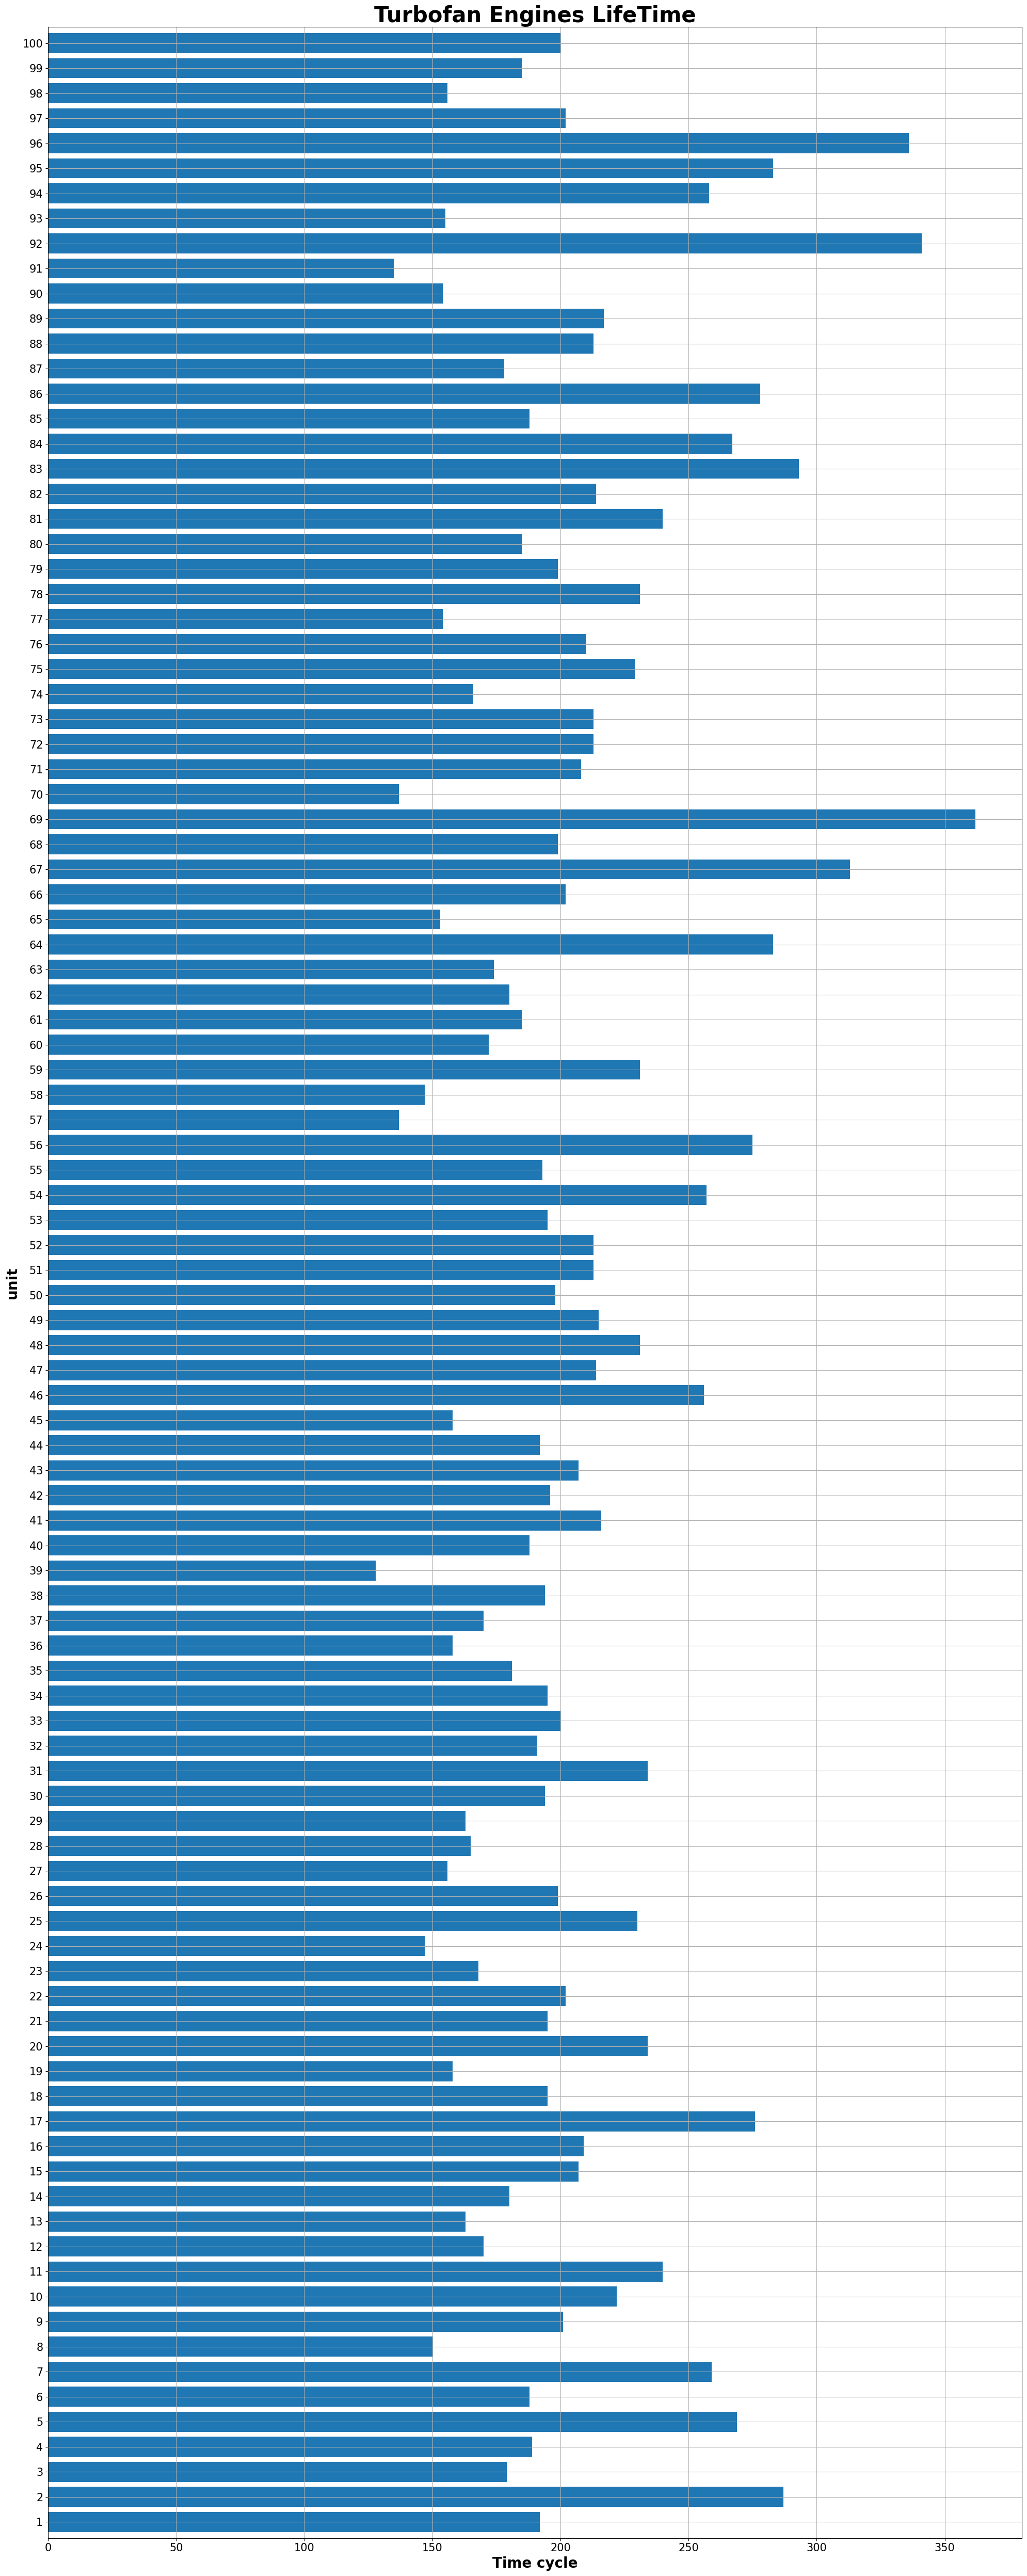

In [13]:
max_time_cycles=train[index_names].groupby('unit_number').max()  # unit_number = Index of Jet Engine (dataset 1 : 1~100)
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'max time cycle')

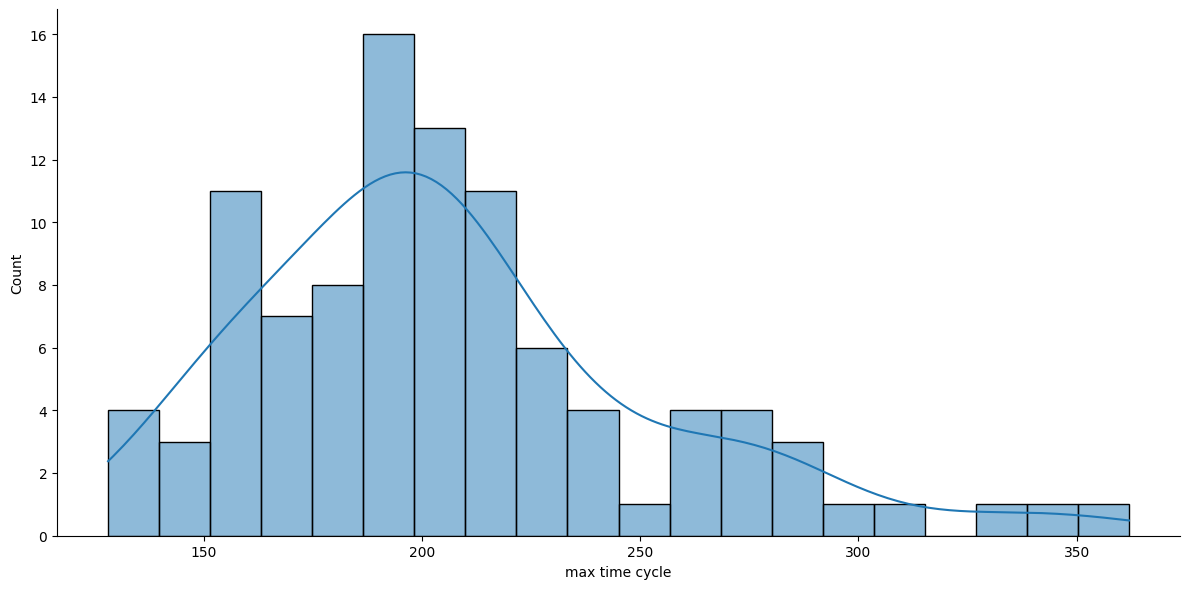

In [14]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

Add RUL column to the data

RUL corresponds to the remaining time cycles for each unit before it falls.

In [15]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [16]:
train = add_RUL_column(train)

In [17]:
train[['unit_number','RUL']]

,unit_number,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187
...,...,...
20626,100,4
20627,100,3
20628,100,2
20629,100,1


In [18]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

Plotting the evolution of features (sensors) along with the evolution with RUL

In [19]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
      #plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())
       if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 10 units only (data : FD001)
           plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero  # xlim() : range of x-axis
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

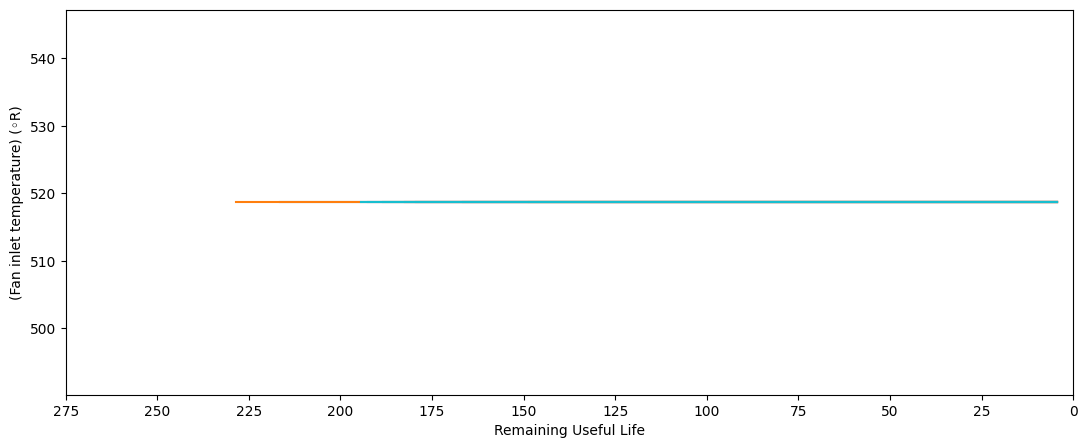

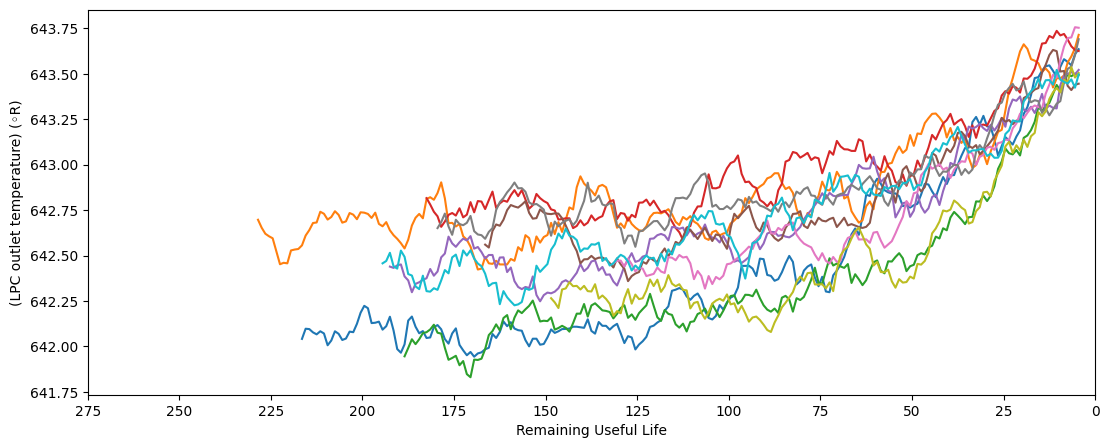

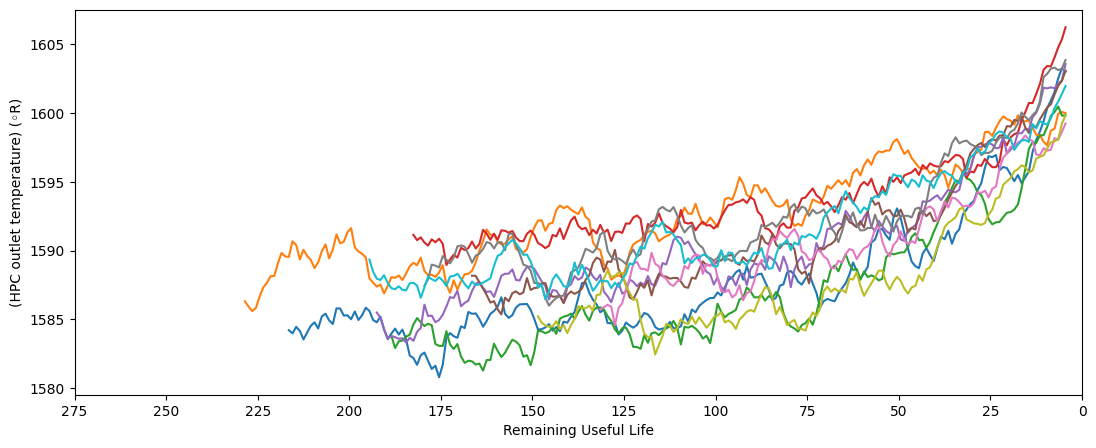

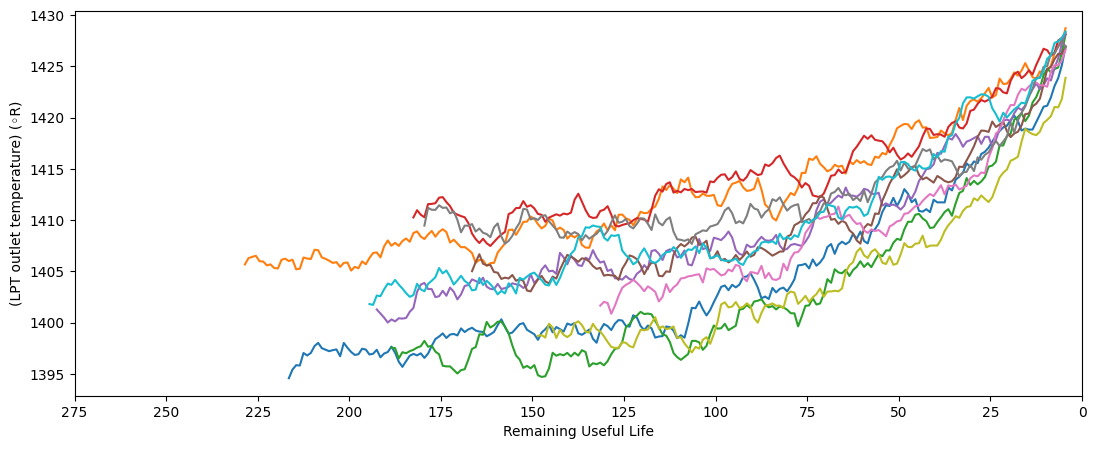

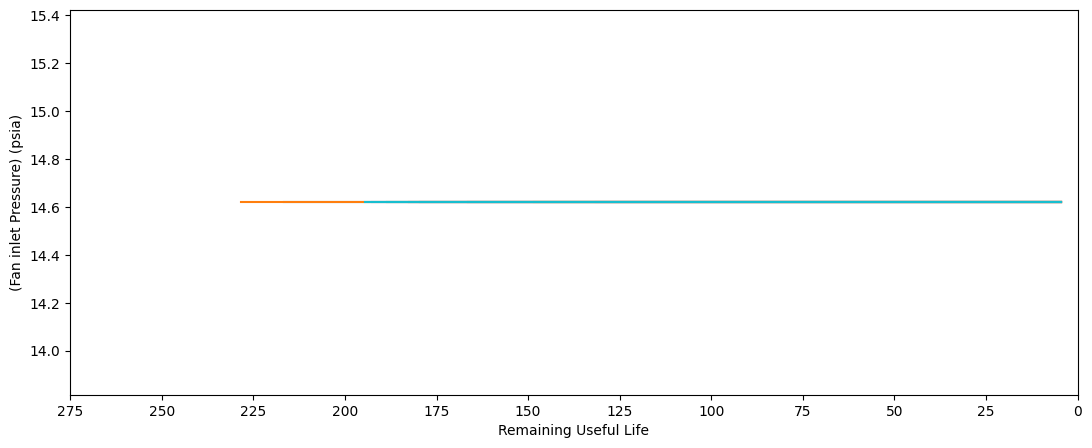

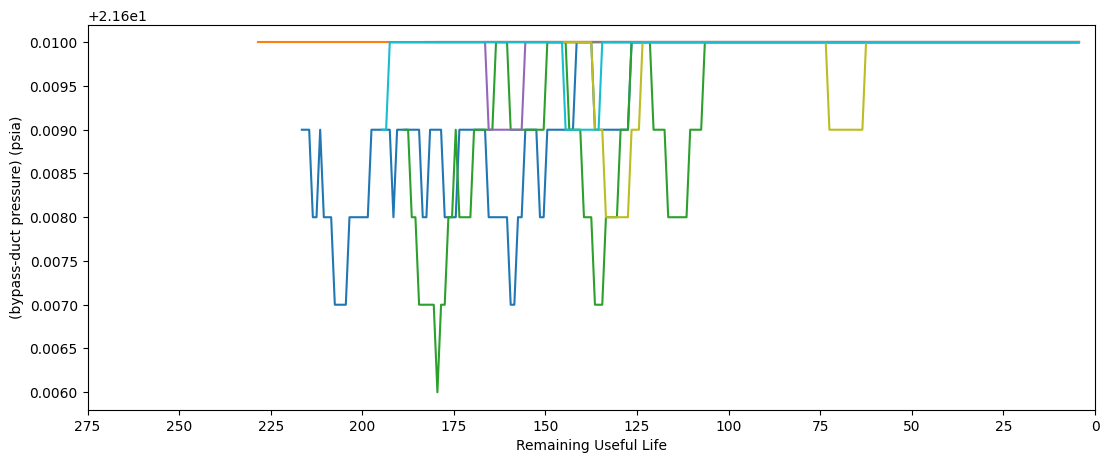

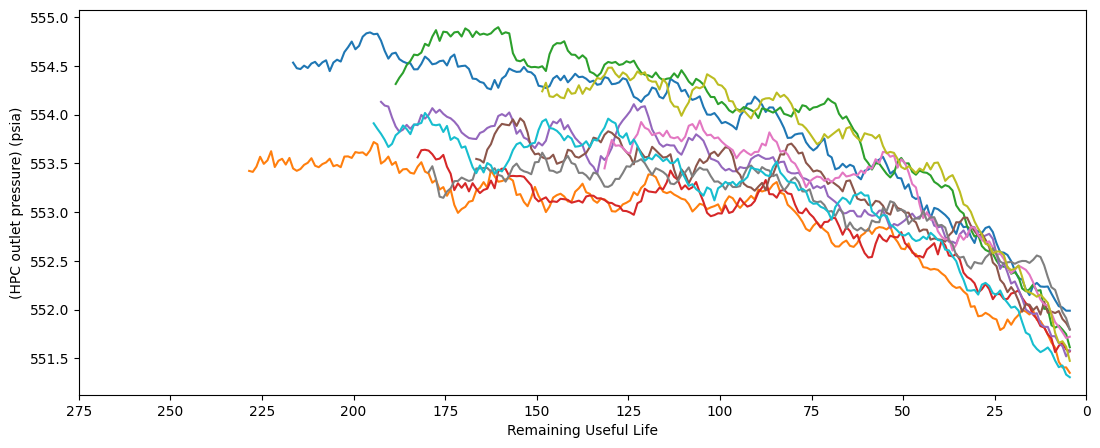

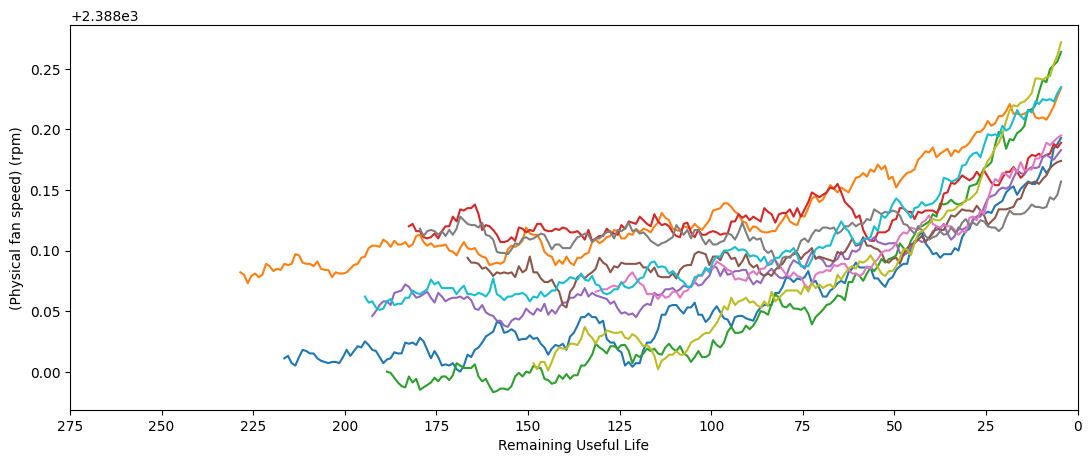

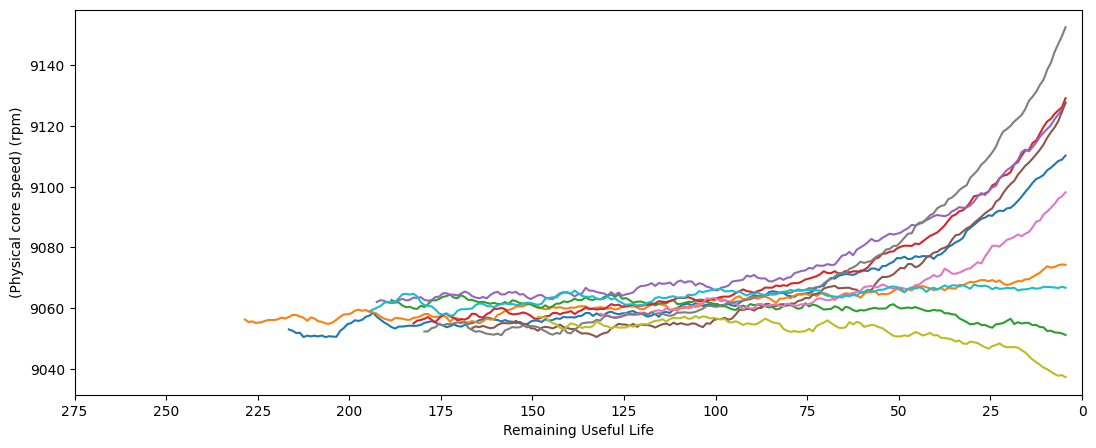

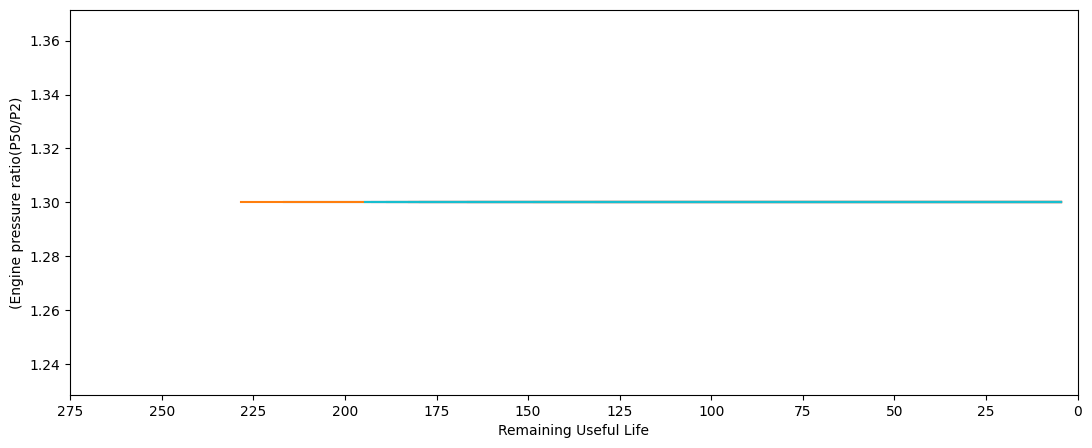

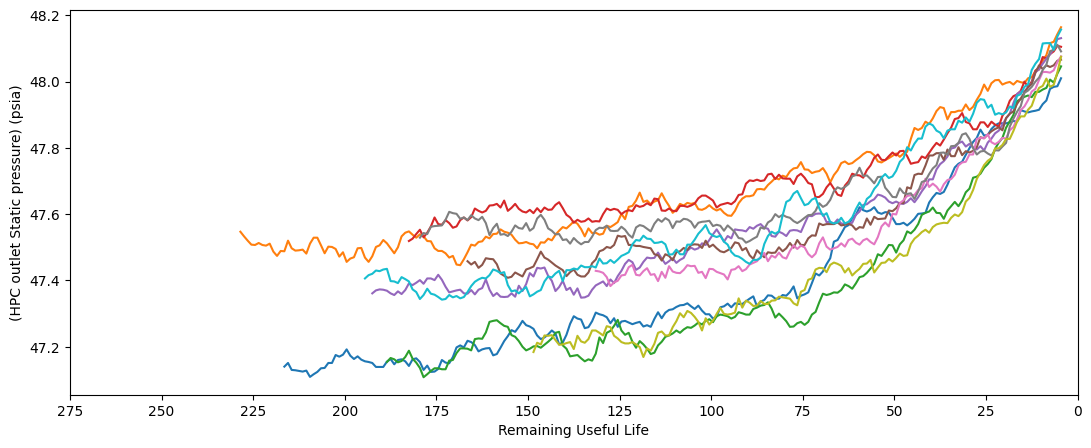

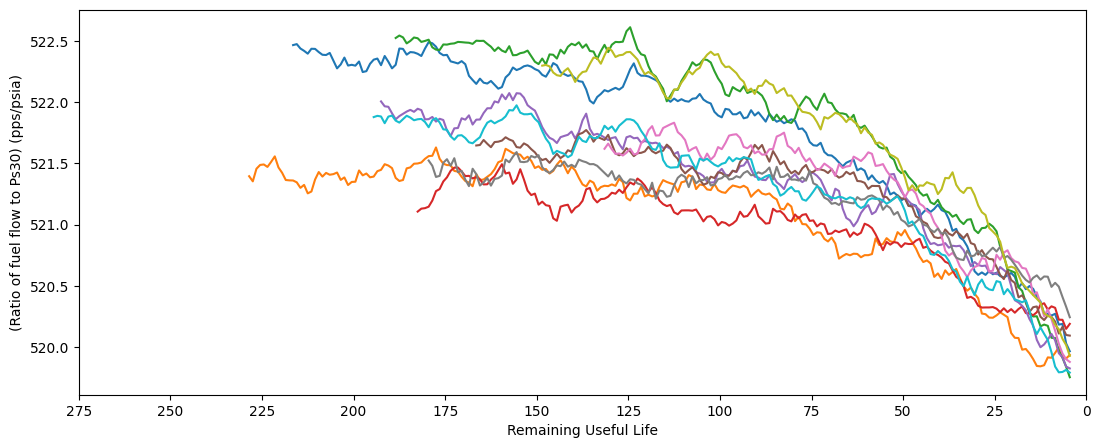

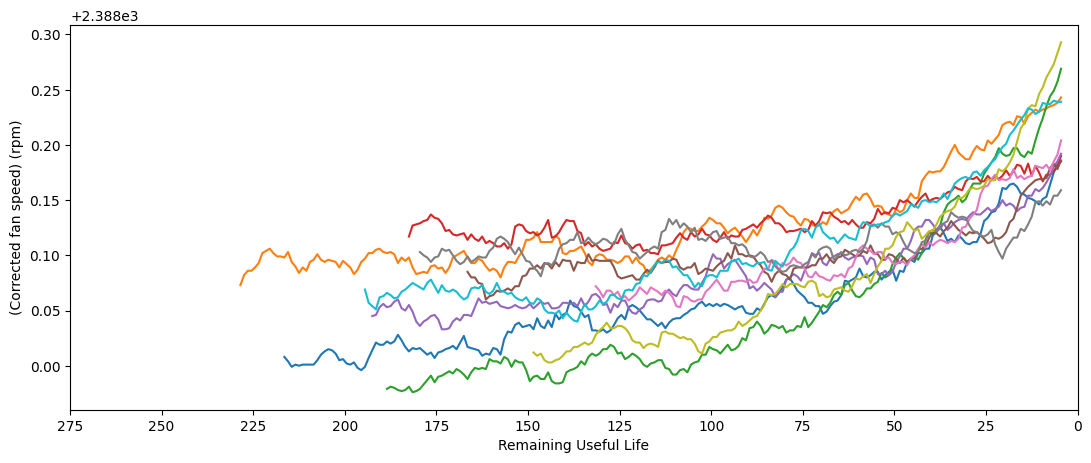

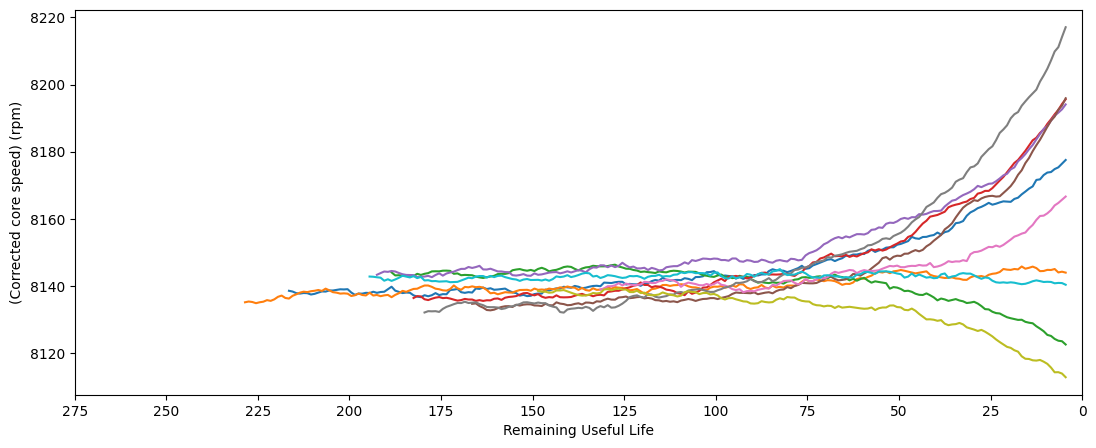

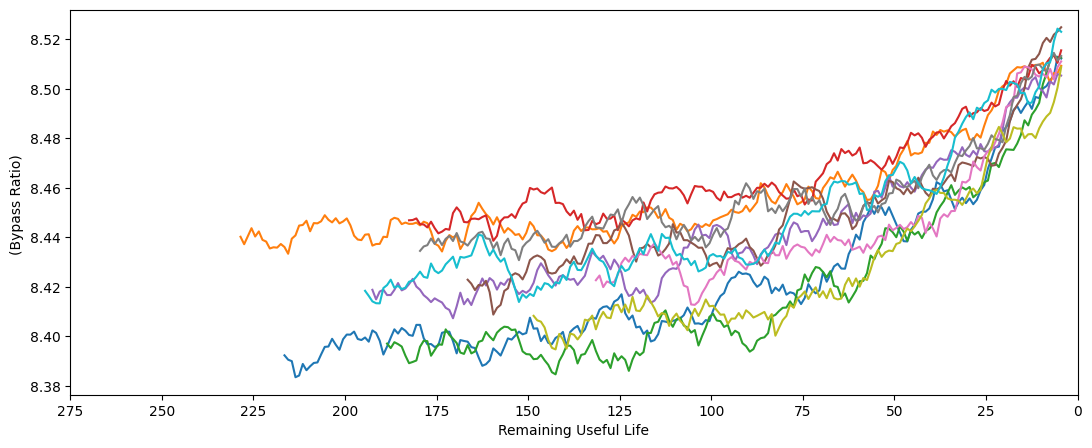

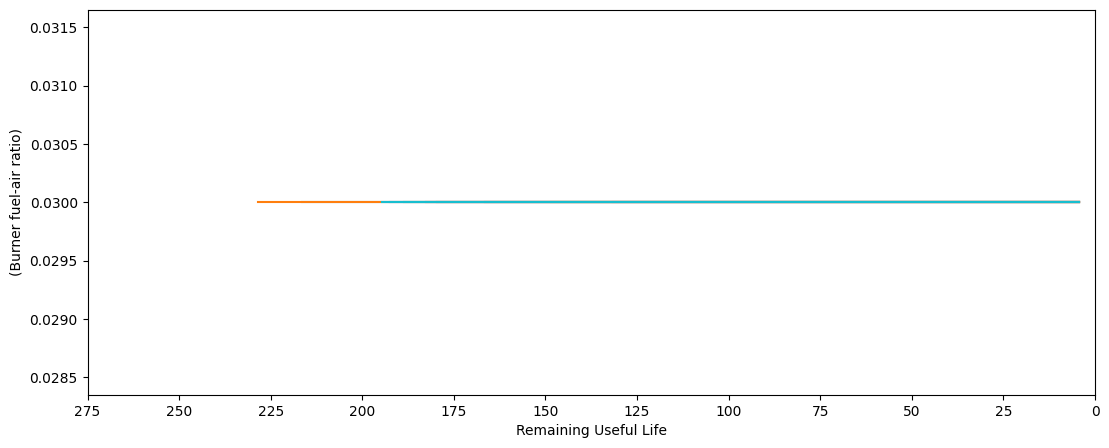

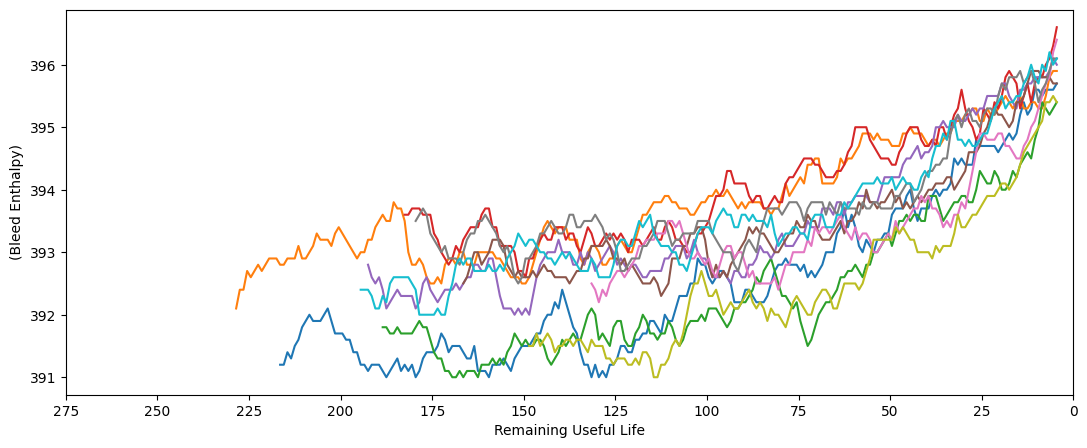

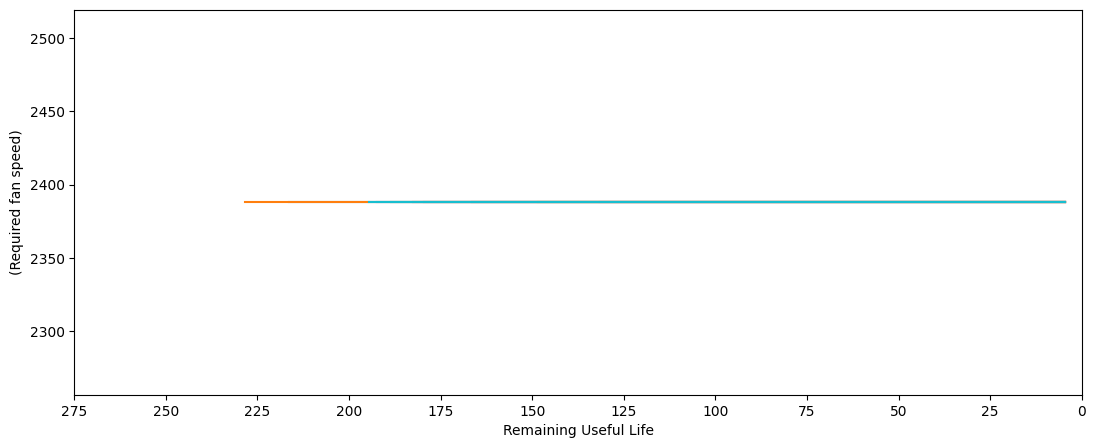

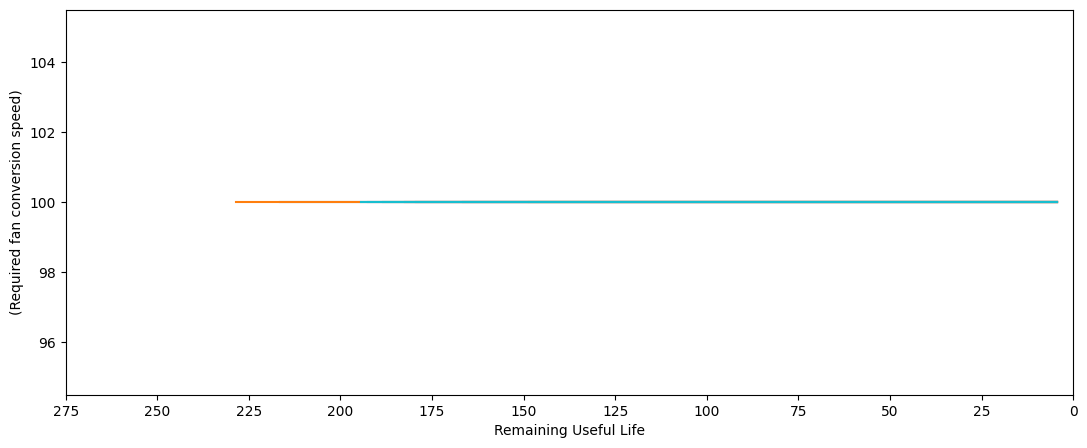

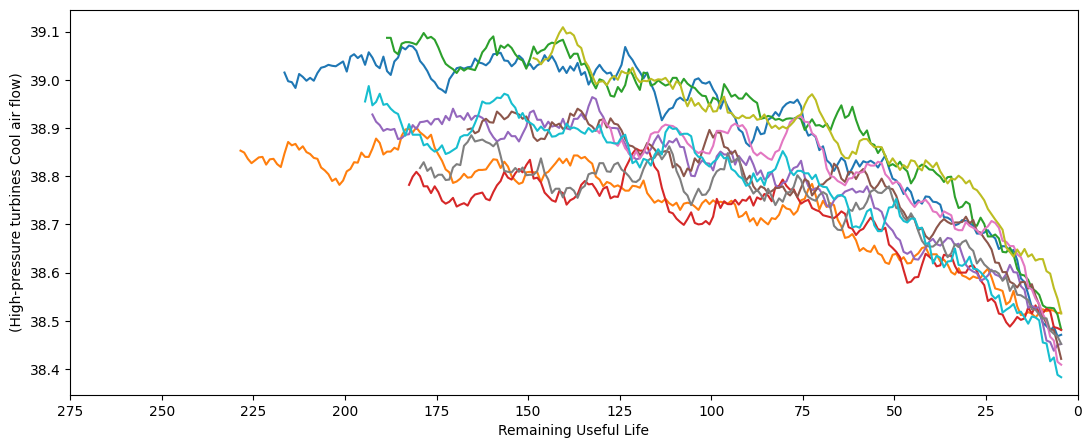

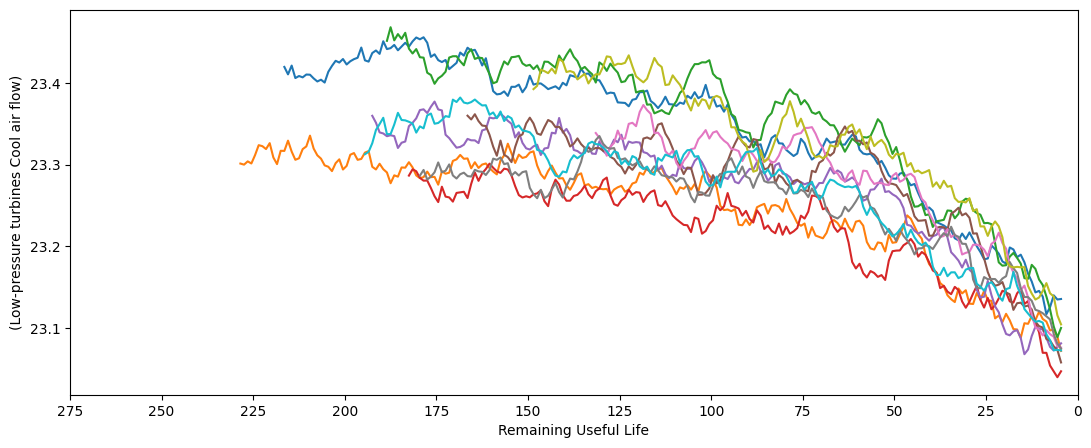

In [20]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

In [21]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


MinMax scaler function : Transform features by scaling each feature to a given range.

This estimater scales and translates each feature individually such that it is in the given range on the training set

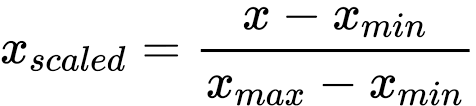

Dropping unnecessary features (labels and settings)

In [22]:
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names
#drop_labels = setting_names

# index_name을 split해서 보관해뒀다가 추후에 병합해줘야 RL에 적용할 수 있음
X_train_unit_num, X_test_unit_num, X_train_time_cycles, X_test_time_cycles  = train_test_split(train['unit_number'], train['time_cycles'], test_size=0.3, random_state=42, shuffle=False)


X_train=train.drop(columns=drop_labels).copy()
# random_state : 42 (for reproducibility), Shuffle = True (default)
#X_train, X_test, y_train, y_test=train_test_split(X_train,X_train['RUL'], test_size=0.3, random_state=42)

# random_state : 42 (for reproducibility), Shuffle = False
# test_size = 0.3으로 분할하는 과정에서 동일한 unit의 time series가 train, test로 나뉘어지는 문제 해결해야함.
# 추후에 RL 적용시, replace를 하게되면 unit간의 전이가 일어날텐데, 이 데이터가 쪼개져있는 것은 문제임 (현재는 unit 72가 쪼개짐)
X_train, X_test, y_train, y_test=train_test_split(X_train,X_train['RUL'], test_size=0.3, random_state=42, shuffle=False)



test code

In [23]:
print(X_train_unit_num)

0         1
1         1
2         1
3         1
4         1
         ..
14436    72
14437    72
14438    72
14439    72
14440    72
Name: unit_number, Length: 14441, dtype: int64


In [24]:
print(X_test_unit_num)

14441     72
14442     72
14443     72
14444     72
14445     72
        ... 
20626    100
20627    100
20628    100
20629    100
20630    100
Name: unit_number, Length: 6190, dtype: int64


In [25]:
print(X_train_time_cycles)

0          1
1          2
2          3
3          4
4          5
        ... 
14436     99
14437    100
14438    101
14439    102
14440    103
Name: time_cycles, Length: 14441, dtype: int64


In [26]:
print(X_test_time_cycles)

14441    104
14442    105
14443    106
14444    107
14445    108
        ... 
20626    196
20627    197
20628    198
20629    199
20630    200
Name: time_cycles, Length: 6190, dtype: int64


In [27]:
print(X_train)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06   
1      518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04   
2      518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08   
3      518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11   
4      518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
14436  518.67  642.43  1587.17  1405.18  14.62  21.61  553.26  2388.14   
14437  518.67  642.72  1586.63  1407.27  14.62  21.61  553.31  2388.10   
14438  518.67  642.82  1593.52  1408.41  14.62  21.61  554.14  2388.13   
14439  518.67  642.28  1589.07  1412.99  14.62  21.61  553.96  2388.09   
14440  518.67  642.33  1588.00  1401.93  14.62  21.61  553.68  2388.07   

           s_9  s_10  ...     s_13     s_14    s_15  s_16  s_17  s_18   s_19  \
0      9046.19   1.3  ...  2388

In [28]:
print(X_test)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
14441  518.67  642.64  1588.09  1414.52  14.62  21.61  553.91  2388.03   
14442  518.67  643.28  1589.35  1399.41  14.62  21.61  553.20  2388.06   
14443  518.67  642.08  1589.42  1405.01  14.62  21.61  553.26  2388.10   
14444  518.67  642.99  1591.48  1407.33  14.62  21.61  554.67  2388.11   
14445  518.67  643.18  1584.50  1405.55  14.62  21.61  553.17  2388.17   
...       ...     ...      ...      ...    ...    ...     ...      ...   
20626  518.67  643.49  1597.98  1428.63  14.62  21.61  551.43  2388.19   
20627  518.67  643.54  1604.50  1433.58  14.62  21.61  550.86  2388.23   
20628  518.67  643.42  1602.46  1428.18  14.62  21.61  550.94  2388.24   
20629  518.67  643.23  1605.26  1426.53  14.62  21.61  550.68  2388.25   
20630  518.67  643.85  1600.38  1432.14  14.62  21.61  550.79  2388.26   

           s_9  s_10  ...     s_13     s_14    s_15  s_16  s_17  s_18   s_19  \
14441  9044.17   1.3  ...  2388

In [29]:
print(y_train) # RUL label of train data

0        191
1        190
2        189
3        188
4        187
        ... 
14436    114
14437    113
14438    112
14439    111
14440    110
Name: RUL, Length: 14441, dtype: int64


In [30]:
print(y_test) # RUL label of test data

14441    109
14442    108
14443    107
14444    106
14445    105
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: RUL, Length: 6190, dtype: int64


Scaling the data

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()  # MinMaxScaler
#Droping the target variable (True RUL)
X_train.drop(columns=['RUL'], inplace=True) # inplace -> true면 원본 삭제 (current option)
X_test.drop(columns=['RUL'], inplace=True)  # inplace -> False면 원본은 유지
#Scaling X_train and X_test
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.fit_transform(X_test)
#Conserve only the last occurence of each unit to match the length of y_valid
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
#scaling X_valid
X_valid_s=scaler.fit_transform(X_valid)

In [32]:
# Checking the presence of Nan values
print('Total None value in the train dataset : ', train.isna().sum())
#print('Total None value in the valid dataset : ', valid.isna().sum())

Total None value in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
RUL            0
dtype: int64


In [33]:
print(X_valid_s.shape)
print(y_valid.shape)

(100, 21)
(100, 1)


In [34]:
print(y_valid)

    RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]


Plotting features new distribution

array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

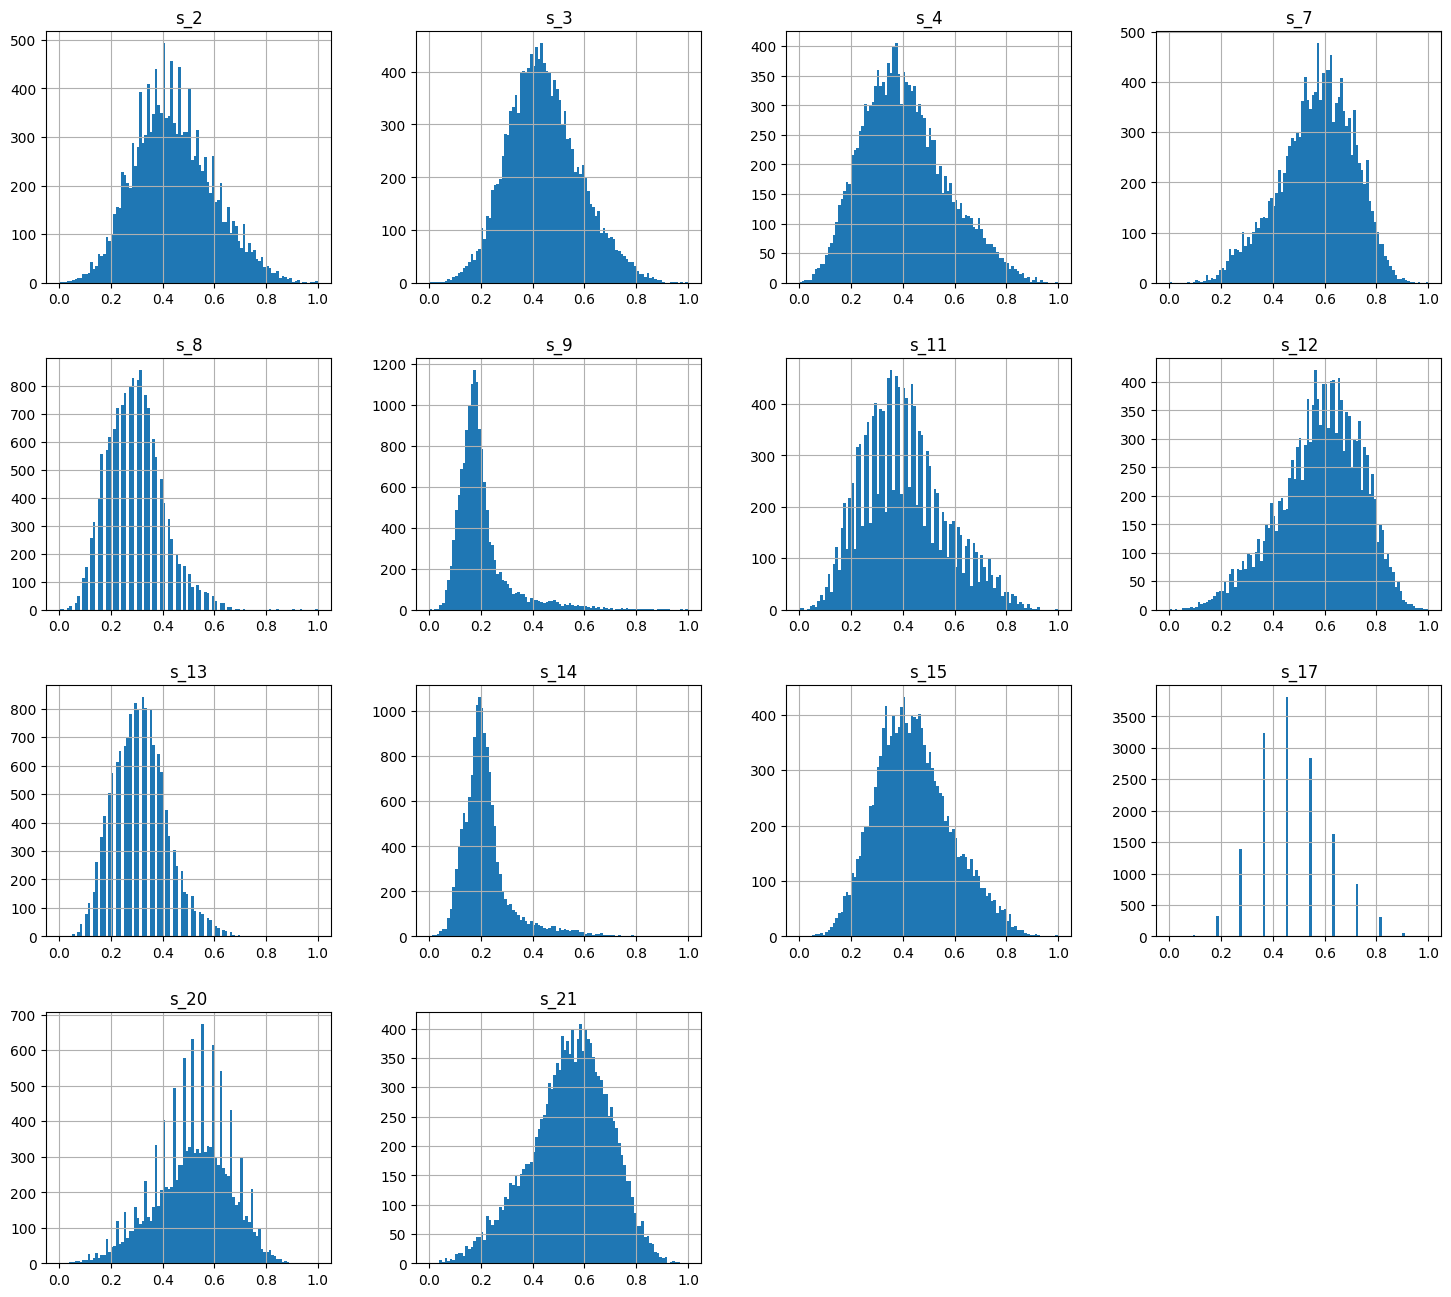

In [35]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

# Model Implementation and instantiation

Linear regression

In [36]:
class Linear_Regression() :
    def __init__( self, lr=0.01, iterations=150 ) :
        self.lr = lr
        self.iterations = iterations
    def fit( self, X, Y ) :
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros( self.p ) # w : 0
        self.b = 0                  # b : 0
        self.X = X
        self.Y = Y
        # gradientlearning
        for i in range( self.iterations ) :
            self.weight_updater()
        return

    def weight_updater( self ) :
        Y_pred = self.predict( self.X )
        #  gradients
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l
        db = - 2 * np.sum( self.Y - Y_pred ) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self

    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b

Support Vector Regression (SVR)

In [37]:
from sklearn.svm import SVR
import tensorflow as tf
regressor = SVR(kernel='rbf')

Random forest

In [38]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

Defining evaluation functions

In [39]:
# R2 score & RMSE & MSE
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat) # R2 score (R-squared) : indep. var.이 depend. var.을 얼마나 잘 설명하는가 (회귀모델 평가지표)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [40]:
# plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values] # y : RUL
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

1st attempt with Feature 3, 4

In [41]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_test : ',y_test.max())
print('maximum of y_valid : ',y_valid.max())

maximum of y_train :  361
maximum of y_test :  340
maximum of y_valid :  RUL    145
dtype: int64


In [42]:
print(X_train)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06   
1      518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04   
2      518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08   
3      518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11   
4      518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
14436  518.67  642.43  1587.17  1405.18  14.62  21.61  553.26  2388.14   
14437  518.67  642.72  1586.63  1407.27  14.62  21.61  553.31  2388.10   
14438  518.67  642.82  1593.52  1408.41  14.62  21.61  554.14  2388.13   
14439  518.67  642.28  1589.07  1412.99  14.62  21.61  553.96  2388.09   
14440  518.67  642.33  1588.00  1401.93  14.62  21.61  553.68  2388.07   

           s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0      9046.19   1.3  ...  521

(array([986., 986., 986., 959., 853., 657., 371., 221., 106.,  65.]),
 array([  0.,  34.,  68., 102., 136., 170., 204., 238., 272., 306., 340.]),
 <BarContainer object of 10 artists>)

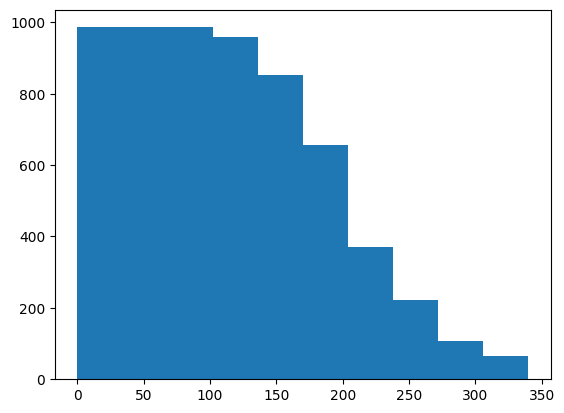

In [43]:
plt.hist(y_test)

In [44]:
# Feature of RUL prediction model (Temp)
# Feature 3 : (HPC outlet temperature) (◦R)
# Feature 4 : (LPT outlet temperature) (◦R)

In [45]:
drop_labels1=['s_1','s_2','s_5','s_6','s_7','s_8','s_9','s_10','s_11','s_12',
              's_13','s_14','s_15','s_16','s_17','s_18','s_19','s_20','s_21']
# drop -> axis : {0 or 'index', 1 or 'columns'}, default 0;
#         columns : axis (labels, axis = 1 is equivalent to index = labels)
X_train_1=X_train.drop(columns=drop_labels1, axis=1) # drop the constant columns from the train dataset (because, axis = 1)
X_test_1=X_test.drop(columns=drop_labels1, axis=1)  # drop the constant columns from the test dataset
X_train_1_s=scaler.fit_transform(X_train_1) #scaling X_train_1
X_test_1_s=scaler.fit_transform(X_test_1) #scaling X_test_1
y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value (it means y = 197 -> y = 195)
X_valid_1=X_valid.drop(columns=drop_labels1, axis=1)  # drop the constant columns from the validation dataset
X_valid_1_s=scaler.fit_transform(X_valid_1) #scaling X_valid_1

Linear regression

In [46]:
lr=Linear_Regression() #Instantiation
lr.fit(X=X_train_1_s, Y=y_train_clip) #Fitting

y_lr_train = lr.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_1_s) #Prediction on test data
evaluate(y_test, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:63.016221145131816, R2:-0.11402000450200678
test set RMSE:78.29536747962071, R2:-0.12800992691000768
valid set RMSE:51.806210721175525, R2:-0.5541900032792528


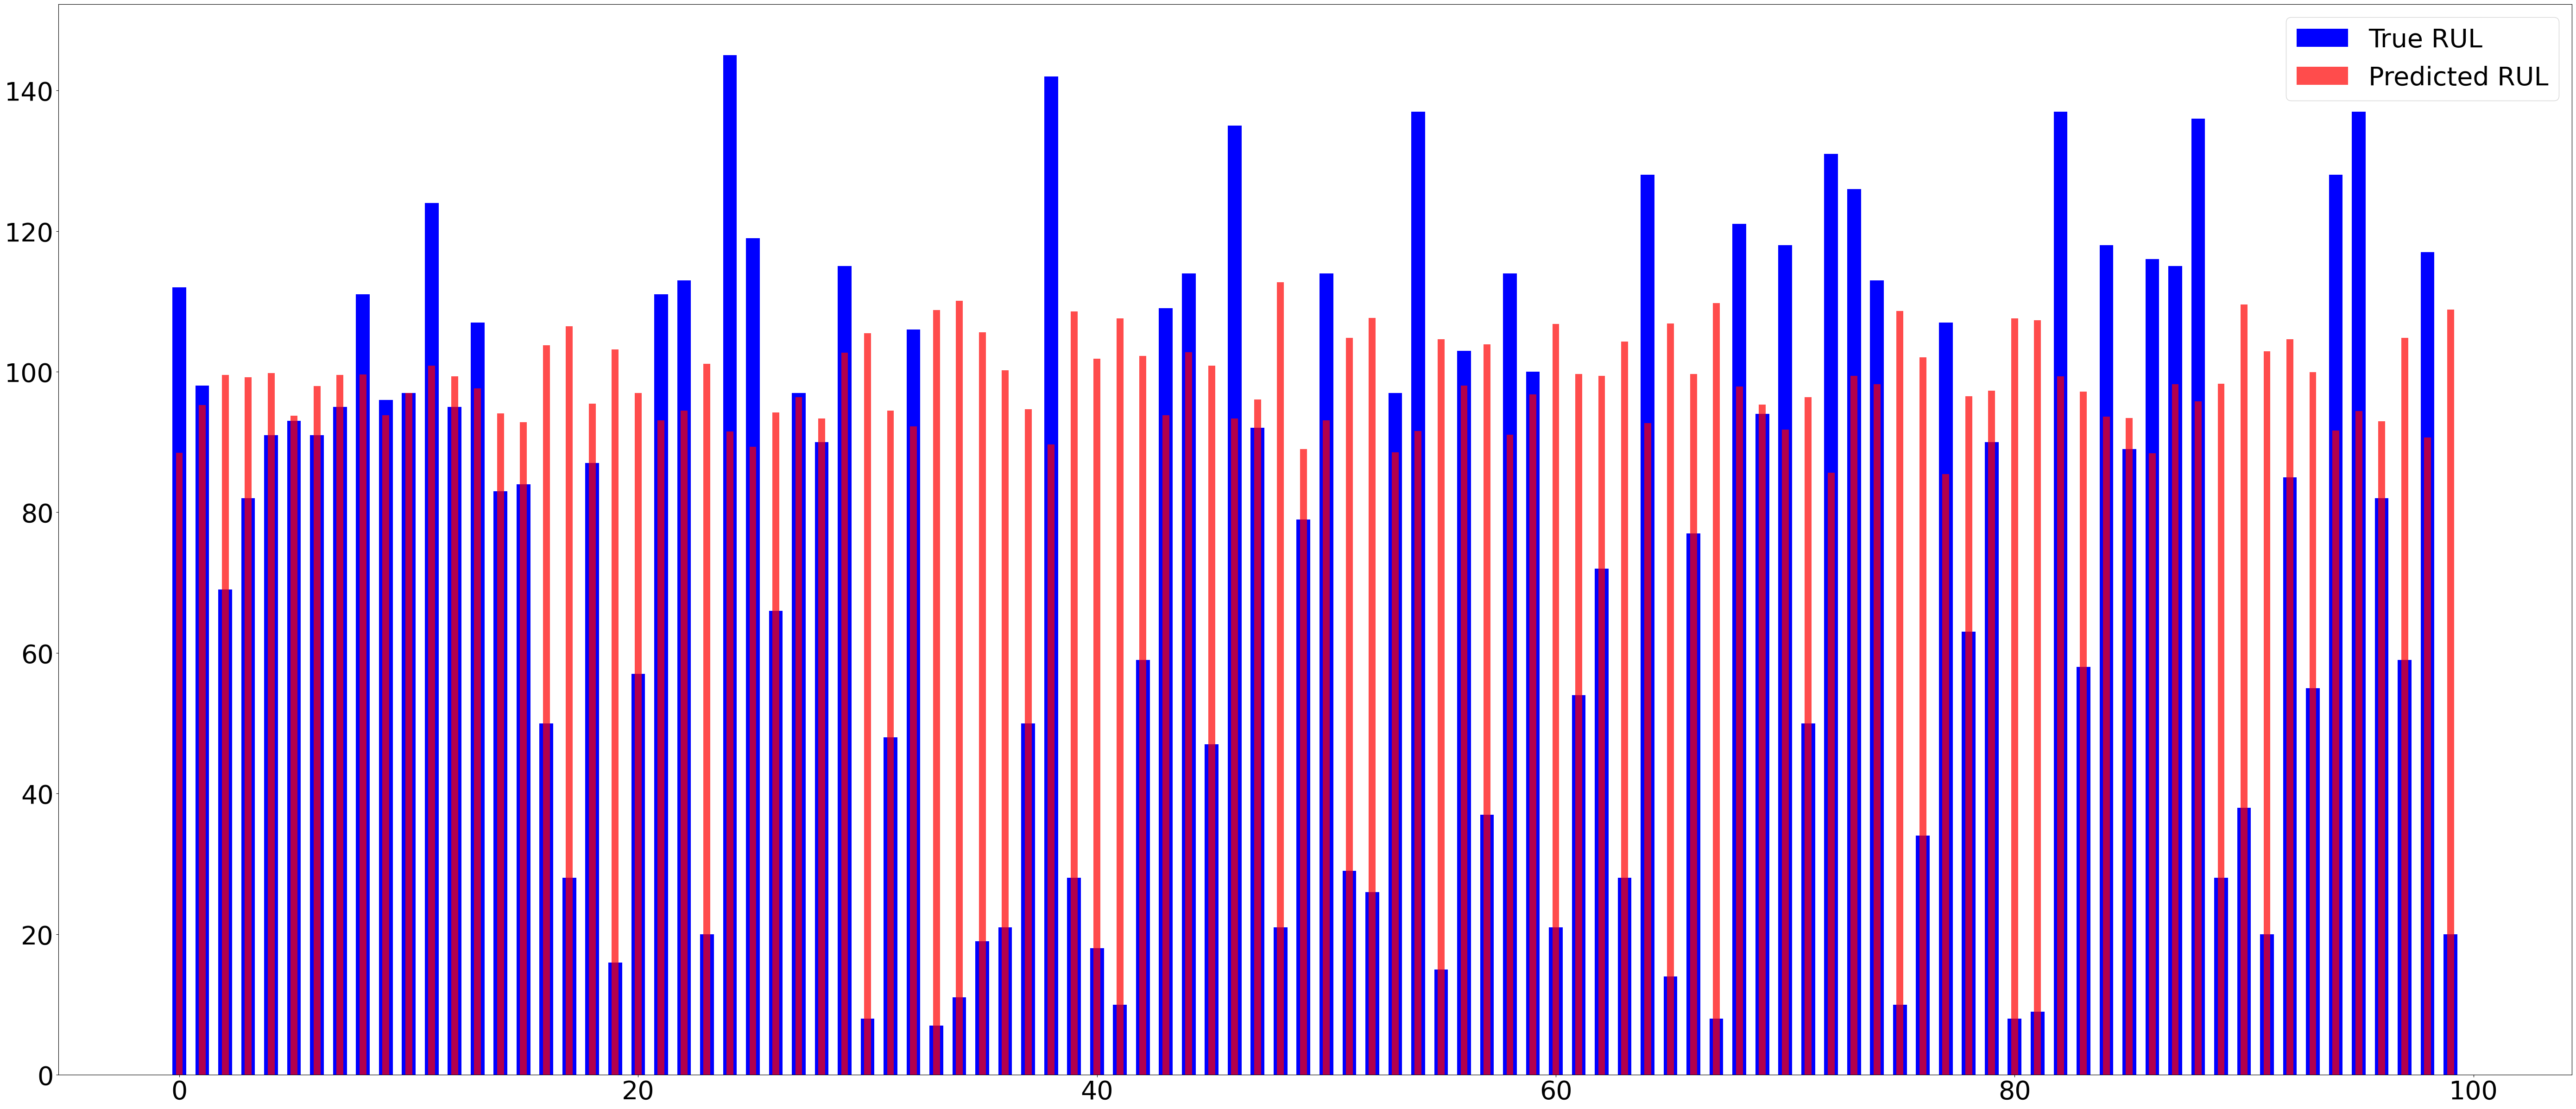

In [47]:
_# linear regression의 한계로 인해 True RUL이 작은 값은 predicted RUL과 차이가 크게 남
plot_predActual(y_valid, y_lr_valid)

# Policy-based RL (REINFORCE Algorithm)

Stochastic policy version

Task 1. Training에서 70개 (혹은 100개) 쓰고 나머지 30개로 test하며 online predict value를 plot. (X-axis : train

In [48]:
# Test dataset은 run to failure data가 아니고, 잘린 데이터까지의 정보로 RUL을 예측하는 것이 목적.
# continue - replace의 decision problem에서, 전체의 데이터가 아닌 이상 이 데이터를 써서 valid를 하긴 어려움.
# Train dataset을 적절히 나눠서 Train, Test를 진행 (RUL prediction에서는 70:30 적용했음).
# Train dataset에서 unit을 변경하며 cumulative reward의 최대화 수행.

Importing libraries (RL)

REINFORCE Algorithm

In [49]:
# policy control parameter theta, y_bar (threshold도 학습의 대상으로 parameter에 들어감)